### 准备Python运行环境

In [ ]:
# 如果未安装 python 环境和相关库，请先运行
# 如果已经成功安装，不需要运行
! pip install networkx
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install seaborn

In [14]:
# 自动屏蔽不必要的报错信息
import warnings
warnings.filterwarnings("ignore")

# 导入相关库
from collections import Counter
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import networkx as nx

### Facebook 大规模实证网络

In [2]:
G_facebook = nx.read_edgelist("Facebook_edges.csv", delimiter=',')
ave_deg = 2 * len(G_facebook.edges) / len(G_facebook.nodes)

print(nx.info(G_facebook))
print(f'Average degree is {ave_deg:.3f}')

Graph with 22472 nodes and 171003 edges
Average degree is 15.219


### 生成网络

**【根据班 Facebook 网络建立无标度网络，如何设置参数？】**  
**【基本要求：具有相同的平均度】**

In [3]:
n = 22472
m = 8

G_sf = nx.barabasi_albert_graph(n, m)
print(nx.info(G_sf))

Graph with 22472 nodes and 179712 edges


### 连通性

In [4]:
print(nx.is_connected(G_facebook))

False


**最大连通集团 Giant connected components, GCC**

In [5]:
largest_cc = max(nx.connected_components(G_facebook), key=len)
Gcc_facebook = G_facebook.subgraph(largest_cc)

### 度分布

大规模网络的度分布，以及双对数坐标曲线下的度分布。

In [6]:
def plot_degree_distriburion(G, ax, title):

    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))

    ax.plot(degrees, degree_freq, 'o')
    ax.set_title(title)
    ax.set(xlabel='Degree', ylabel='Frequency')

    ax.label_outer()

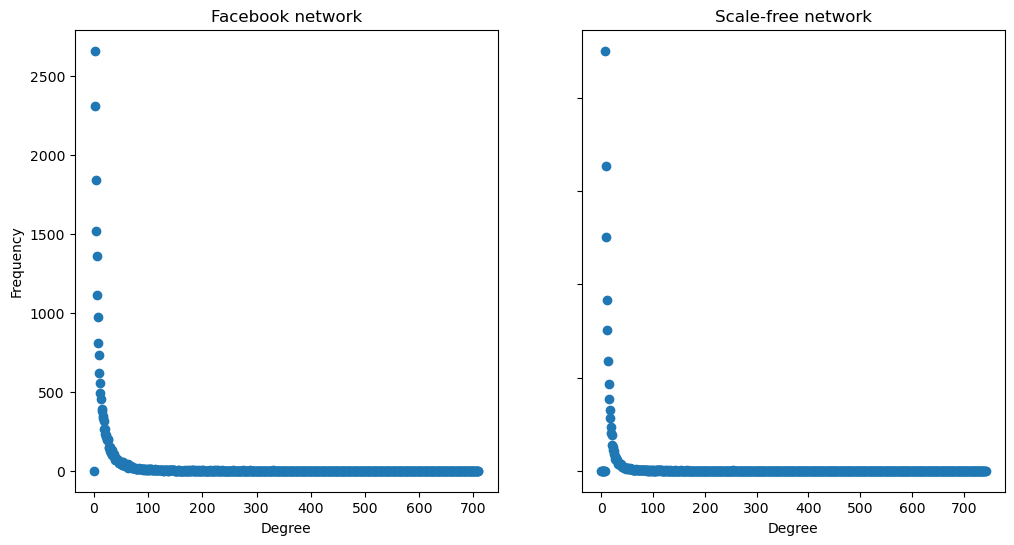

In [7]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

plot_degree_distriburion(Gcc_facebook, axes[0], 'Facebook network')
plot_degree_distriburion(G_sf, axes[1], 'Scale-free network')

plt.show()

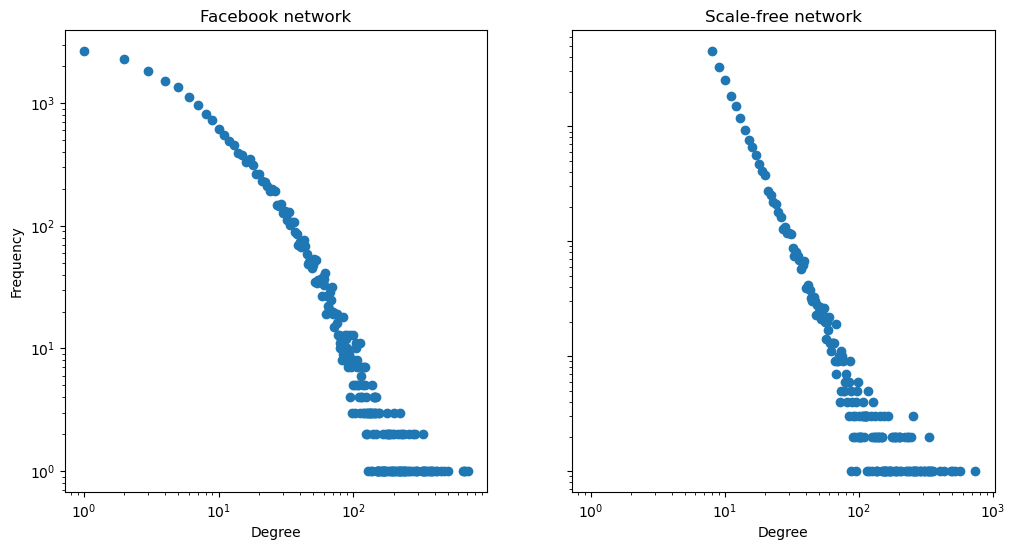

In [8]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
axes[0].set(xscale="log", yscale="log")
axes[1].set(xscale="log", yscale="log")

plot_degree_distriburion(Gcc_facebook, axes[0], 'Facebook network')
plot_degree_distriburion(G_sf, axes[1], 'Scale-free network')

plt.show()

【“低头现象”可能的原因？】

### 增长择优模型 Growth and preferential attachment

有许多网络生成机制能够产生无标度现象，其中比较有名的是 Barabasi 和 Albert 在 1999 年提出的增长择优模型。

1. 生成一个初始网络；
2. 新增一个节点；
3. 每一个新节点带有 m 条连边，按照一定规则连接已有节点；   
4. 重复步骤 (2)(3)，直到网络规模达到要求。

其中，现有节点的度（k）越大，越容易被新节点连接。择优的规则为：
$$P(i)=\frac{k_i}{\sum{k_j}}$$

**第一步，从初始网络开始**

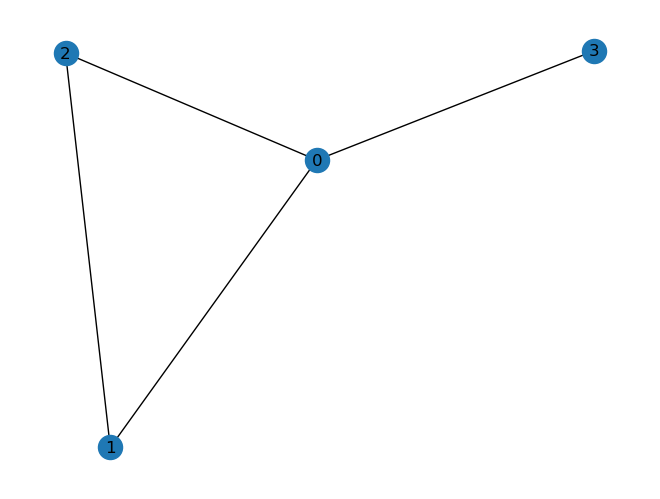

In [9]:
G0 = nx.Graph()
G0.add_edges_from([(0, 1), (1, 2), (0, 2), (0, 3)])
nx.draw(G0, with_labels=True)
i = 3

**第二步，新增加一个节点（增长）**

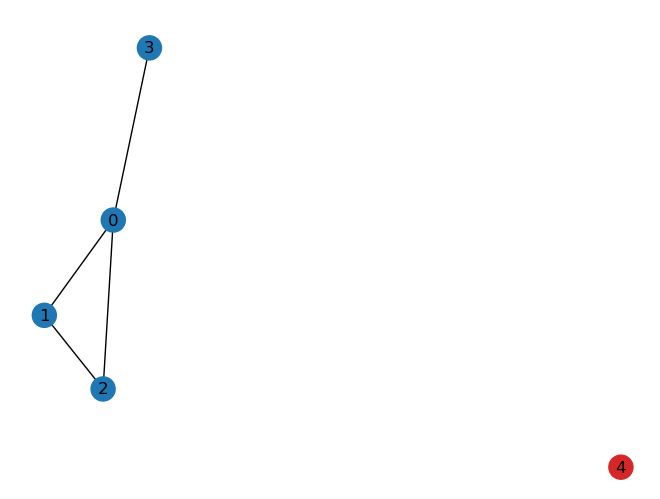

In [10]:
i += 1

color_map = ['tab:blue'] * i
color_map.append('tab:red')

G1 = G0.copy()
G1.add_node(i)
nx.draw(G1, node_color=color_map, with_labels=True)

**第三步，与已有节点相连（择优）**

In [11]:
possible_neighbors = list(G0.nodes)
degrees = [G0.degree(n) for n in possible_neighbors]

In [12]:
neighbors_to_choose = [[n] * G0.degree(n) for n in possible_neighbors]
neighbors_to_choose = [i for l in neighbors_to_choose for i in l]
neighbors_to_choose

[0, 0, 0, 1, 1, 2, 2, 3]

In [15]:
j = random.choices(neighbors_to_choose)[0]
print('new neighbor is %d' % j)

new neighbor is 1


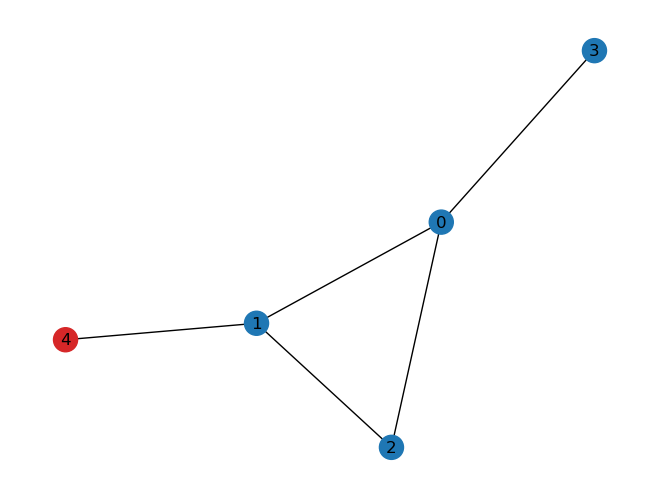

In [16]:
G0.add_edge(i, j)

nx.draw(G0, node_color=color_map, with_labels=True)

**重复 N 遍**

In [17]:
def get_SF(G):
    
    i = len(G.nodes())
    
    possible_neighbors = list(G.nodes)
    degrees = [G.degree(n) for n in possible_neighbors]
    
    neighbors_to_choose = [[n] * G.degree(n) for n in possible_neighbors]
    neighbors_to_choose = [i for l in neighbors_to_choose for i in l]
    j = random.choices(neighbors_to_choose)[0]
    G.add_edge(i, j)

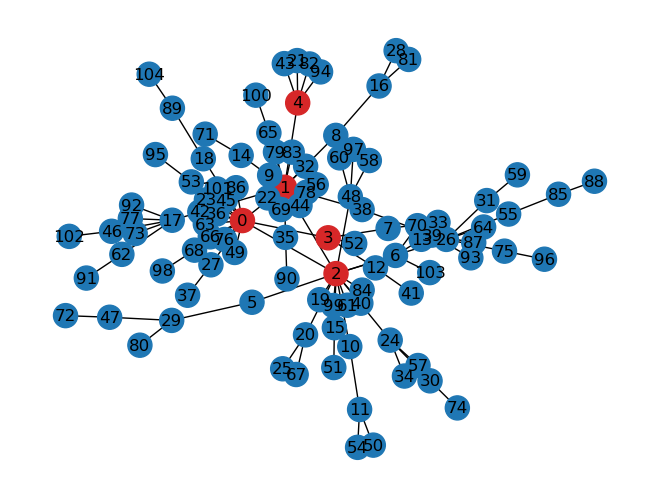

In [18]:
G = G0.copy()
N = 100

for i in range(N):
    get_SF(G)

color_map =  ['tab:red']*5 + ['tab:blue'] * (len(G)-5)
nx.draw(G, node_color=color_map, with_labels=True)

### 同配性 Assortative

In [23]:
print(f"实证网络的同配性系数：{nx.degree_assortativity_coefficient(Gcc_facebook):.2f}")
print(f"无标度网络的同配性系数：{nx.degree_assortativity_coefficient(G_sf):.2f}")

实证网络的同配性系数：0.09
无标度网络的同配性系数：-0.02


### 平均距离和集聚系数

In [21]:
def sample_distance(G):
    
    nodes = list(G.nodes())
    distance_list = []
    
    for a in range(10000):
        i, j = random.choices(nodes, k=2)
        distance_list.append(nx.shortest_path_length(G, i, j))
        
    return sum(distance_list) / len(distance_list)

In [22]:
print(f"Facebook 网络的平均距离为 {sample_distance(Gcc_facebook):.2f}")

largest_cc = max(nx.connected_components(G_sf), key=len)
Gcc_sf = G_sf.subgraph(largest_cc)
print(f"无标度网络的平均距离为     {sample_distance(Gcc_sf):.2f}")

Facebook 网络的平均距离为 4.97
无标度网络的平均距离为     3.48


**【结论：在平均距离层面，无标度网络与实证网络相符】**  

In [23]:
print(f"Facebook 网络的平均集聚系数为 {nx.average_clustering(Gcc_facebook):.2f}")
print(f"无标度网络的平均集聚系数为    {nx.average_clustering(Gcc_sf):.2f}")

Facebook 网络的平均集聚系数为 0.36
无标度网络的平均集聚系数为    0.00


**【结论：在集聚系数层面，无标度网络与实证网络不相符】**  

### 稳健性 Resilience

网络受到攻击，意味着一些节点以及它们的连边被剥离出网络。如果网络受到攻击后仍然连通，则认为网络是稳健的。

In [24]:
G = Gcc_facebook

**随机攻击**

In [25]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
num_nodes_removed = range(0, G.number_of_nodes(), M)

In [26]:
N = G.number_of_nodes()
C = G.copy()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = max(nx.connected_components(C), key=len)
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

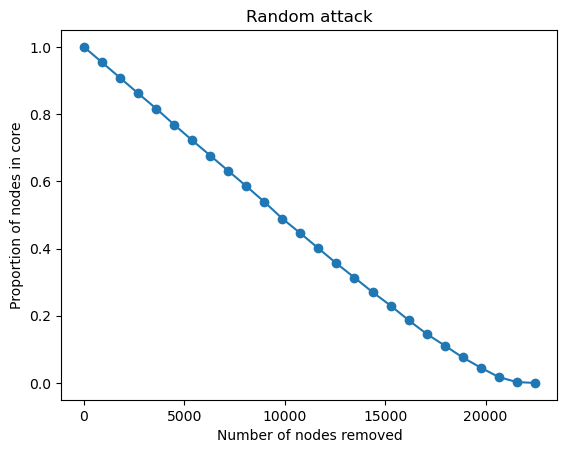

In [27]:
plt.title('Random attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')
plt.show()

**蓄意攻击**

In [28]:
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]

for node in top_degree_nodes[:5]:
    print('node %s has degree with %d' % (node, G.degree(node)))

node 16895 has degree with 709
node 19743 has degree with 678
node 21729 has degree with 659
node 14497 has degree with 650
node 1387 has degree with 504


In [29]:
N = G.number_of_nodes()
number_of_steps = 25
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    targeted_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select top M nodes and remove them
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)

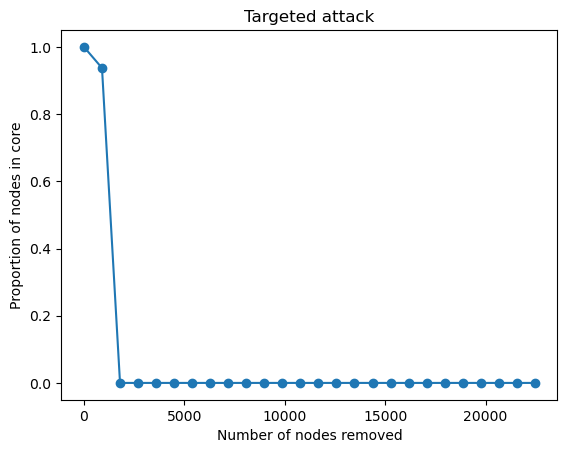

In [30]:
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')
plt.show()

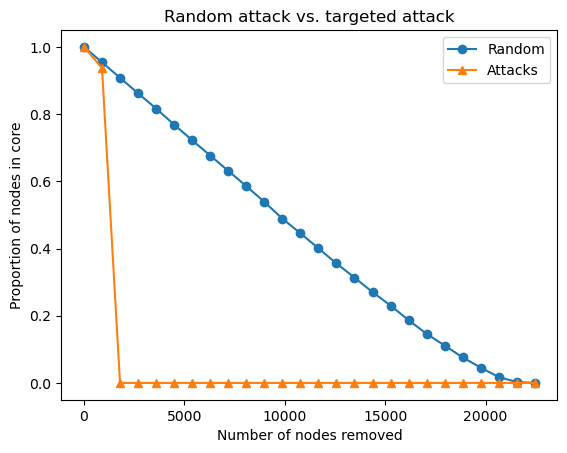

In [31]:
plt.title('Random attack vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Random')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='^', label='Attacks')
plt.legend()
plt.show()